# A Classification Neural Network Designed for Multiclass Pose Detection with Pytorch and Scklearn

## In Developement

# Preprocessing data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mediapipe as mp 
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Get dataset from csv
df = pd.read_csv('hands-coords.csv')
df.head()

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
0,OPEN,0.133079,0.803265,-0.000003,0.223318,0.755159,-0.065259,0.298350,0.650100,-0.107756,...,-0.138427,0.005162,0.452539,-0.202575,0.003198,0.384908,-0.243605,0.010728,0.336541,-0.276406
1,OPEN,0.150588,0.767340,-0.000077,0.250065,0.709875,-0.074892,0.325554,0.615681,-0.119330,...,-0.090350,0.042382,0.370480,-0.142733,0.040724,0.320515,-0.190375,0.042421,0.293379,-0.223604
2,OPEN,0.189386,0.734750,-0.000055,0.286886,0.692143,-0.072405,0.362686,0.602163,-0.113038,...,-0.094121,0.096428,0.339823,-0.142506,0.090486,0.281070,-0.178169,0.086609,0.229779,-0.204797
3,OPEN,0.216902,0.730650,-0.000090,0.318528,0.684575,-0.054690,0.395420,0.595470,-0.085698,...,-0.094849,0.128114,0.326521,-0.142430,0.121402,0.258354,-0.186646,0.115474,0.193716,-0.220493
4,OPEN,0.236359,0.743055,-0.000109,0.335344,0.696353,-0.048366,0.410177,0.602037,-0.073905,...,-0.094502,0.151234,0.340649,-0.141837,0.146338,0.269274,-0.182816,0.141425,0.202615,-0.212230


In [3]:
df.shape

(6554, 64)

<AxesSubplot:xlabel='class', ylabel='count'>

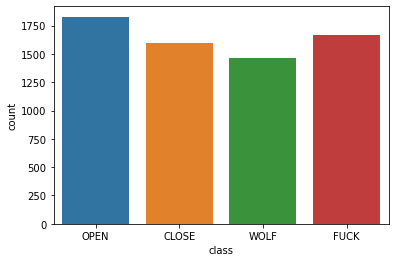

In [4]:
sns.countplot(x = 'class', data=df)

<AxesSubplot:title={'center':'Y axis'}, xlabel='class'>

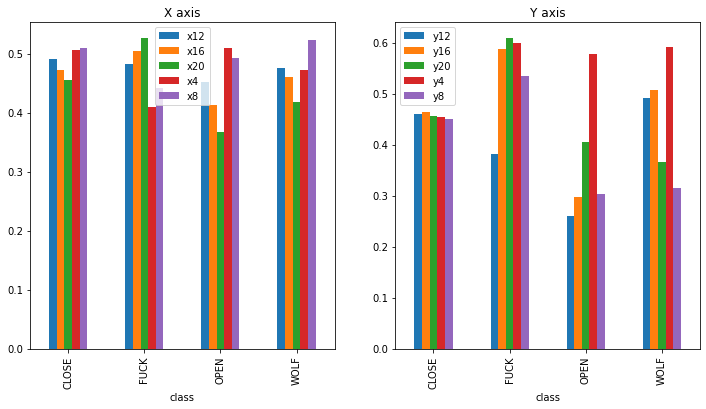

In [5]:
# Hand Model Visualization
df_pivot_x = pd.pivot_table(
    df, 
    values=["x4", "x8", "x12", "x16", "x20"],
    index="class", 
    aggfunc=np.mean
)
df_pivot_y = pd.pivot_table(
    df, 
    values=["y4", "y8", "y12", "y16", "y20"],
    index="class", 
    aggfunc=np.mean
)
fig, axes = plt.subplots(1,2,figsize=(12,6))
df_pivot_x.plot(kind="bar", title="X axis", ax=axes[0])
df_pivot_y.plot(kind="bar", title="Y axis", ax=axes[1])


In [6]:
# Encode the class
le = LabelEncoder()
le.fit(df['class'])
df['class_encoded'] = le.transform(df['class'])

X = df.drop(['class', 'class_encoded'], axis=1)
y = df['class_encoded']

In [7]:
# Divide it to trainval and test splits
X_trainval, X_test, y_trainval, y_test = train_test_split(X,y, stratify=y, test_size=0.3, random_state=69)


# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [8]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

# Neural Network Design with PyTorch

## Creating custom datasets

In [9]:
class GestureDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.y_data)
    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

In [10]:
train_dataset = GestureDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = GestureDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = GestureDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

## Weighted Sampling

Because there’s a class imbalance, we use stratified split to create our train, validation, and test sets.
While it helps, it still does not ensure that each mini-batch of our model see’s all our classes. We need to over-sample the classes with less number of values. To do that, we use the WeightedRandomSampler.

In [11]:
def get_class_distribution(obj, max_num_class):
    count_dict = {}
    for i in range(max_num_class+1):
        count_dict[i] = 0
    
    for i in obj:
        count_dict[i] += 1
            
    return count_dict

In [12]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [13]:
class_count = [i for i in get_class_distribution(y_train, int(max(target_list))).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0010, 0.0010, 0.0009, 0.0011])


In [14]:
class_weights_all = class_weights[target_list]
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

## Modeling

In [15]:
class GestureClassifierNet(nn.Module):
    def __init__(self, num_feature, num_class):
        super(GestureClassifierNet, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x
        

In [16]:
EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = max(y) + 1

model = GestureClassifierNet(num_feature = NUM_FEATURES, num_class = NUM_CLASSES)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler,
                          drop_last=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

GestureClassifierNet(
  (layer_1): Linear(in_features=63, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Training the Model

This function takes y_pred and y_test as input arguments. We then apply log_softmax to y_pred and extract the class which has a higher probability.
After that, we compare the the predicted classes and the actual classes to calculate the accuracy.

In [17]:
# accuracy function
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [18]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [19]:
# Training
for e in range(EPOCHS):

    train_epoch_loss = 0
    train_epoch_acc = 0

    # TRAINING
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

    if e%50==0:
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Epoch 000: | Train Loss: 0.25237 | Val Loss: 0.02446 | Train Acc: 96.039| Val Acc: 100.000
Epoch 050: | Train Loss: 0.00971 | Val Loss: 0.00096 | Train Acc: 99.721| Val Acc: 100.000


In [20]:
print(f'Final: Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Final: Train Loss: 0.00035 | Val Loss: 0.00000 | Train Acc: 100.000| Val Acc: 100.000


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

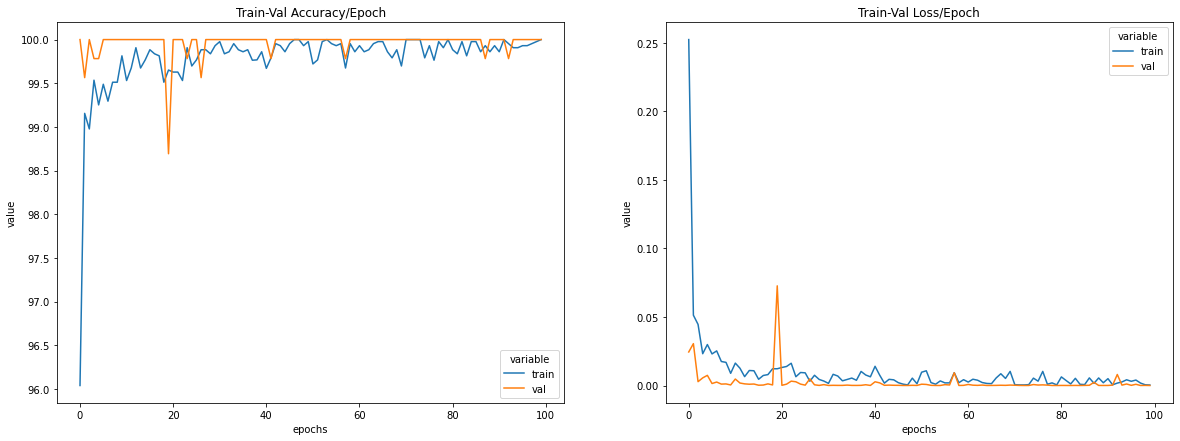

In [21]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Prediction and Evaluation

In [22]:
y_pred_list = []
with torch.no_grad():
    test_loss=0
    test_acc=0
    model.eval()
    for X_batch, Y_batch in test_loader:
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

        test_it_loss = criterion(y_test_pred, Y_batch)
        test_it_acc = multi_acc(y_test_pred, Y_batch)
        
        test_loss += test_it_loss.item()
        test_acc += test_it_acc.item()

    loss_stats['test'] = (test_loss/len(test_loader))
    accuracy_stats['test'] = (test_acc/len(test_loader))
        

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

loss_stats['test'], accuracy_stats['test']

(0.004992634844199868, 99.84748347737671)

<AxesSubplot:>

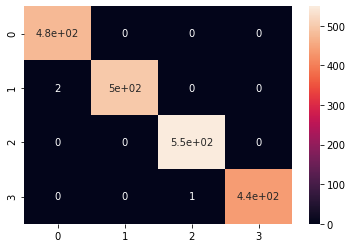

In [23]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True)

In [24]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       478
           1       1.00      1.00      1.00       501
           2       1.00      1.00      1.00       549
           3       1.00      1.00      1.00       439

    accuracy                           1.00      1967
   macro avg       1.00      1.00      1.00      1967
weighted avg       1.00      1.00      1.00      1967



## Live Detection

In [25]:
mp_drawing = mp.solutions.drawing_utils # Drawing helper
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic

### Holistic Model

In [88]:
import traceback
cap = cv2.VideoCapture(0)
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        # Make Detections
        results = holistic.process(image)
        # print(results.face_landmarks)
        
        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # 1. Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )
        
        # 2. Right hand
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )

        # 3. Left Hand
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )

        # 4. Pose Detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )
        # Export coordinates
        try:
            # Extract Pose landmarks
            pose = results.pose_landmarks.landmark
            pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
            
            # Extract Face landmarks
            face = results.face_landmarks.landmark
            face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
            
            # Concate rows
            row = pose_row+face_row
            
            # Make Detections
            X = pd.DataFrame([row])
            #X = scaler.fit_transform(X)
            X = np.array(X)

            # mylist.append(list(*X))
            # if(counter %  50 == 0):
            #     print('saving')
            #     a = np.array(mylist)
            #     np.savetxt("foo1.csv", a, delimiter=",")
            # print(counter)
            X = torch.tensor(X, dtype=torch.float32)

            with torch.no_grad():
                model.eval()
                y_test_pred = model(X)
                _, y_pred_tags = torch.max(y_test_pred, dim = 1)
                body_language_class = le.inverse_transform(y_pred_tags.cpu().numpy())[0]
                #print(body_language_class)
            
            # Grab ear coords
            coords = tuple(np.multiply(
                            np.array(
                                (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
                                 results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y))
                        , [640,480]).astype(int))
            
            cv2.rectangle(image, 
                          (coords[0], coords[1]+5), 
                          (coords[0]+len(body_language_class)*20, coords[1]-30), 
                          (245, 117, 16), -1)
            cv2.putText(image, body_language_class, coords, 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Get status box
            cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
            
            # Display Class
            cv2.putText(image, 'CLASS'
                        , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, body_language_class.split(' ')[0]
                        , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # # Display Probability
            # cv2.putText(image, 'PROB'
            #             , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            # cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)],2))
            #             , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
        except:
            traceback.print_exc()
                        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


Traceback (most recent call last):
  File "<ipython-input-88-a121c4ca6d78>", line 49, in <module>
    pose = results.pose_landmarks.landmark
AttributeError: 'NoneType' object has no attribute 'landmark'
Traceback (most recent call last):
  File "<ipython-input-88-a121c4ca6d78>", line 74, in <module>
    y_test_pred = model(X)
  File "C:\Users\Faraz Khoubsirat\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "<ipython-input-76-c378d3c34359>", line 17, in forward
    x = self.layer_1(x)
  File "C:\Users\Faraz Khoubsirat\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "C:\Users\Faraz Khoubsirat\anaconda3\lib\site-packages\torch\nn\modules\linear.py", line 96, in forward
    return F.linear(input, self.weight, self.bias)
  File "C:\Users\Faraz Khoubsirat\anaconda3\lib\site-packages\torch\nn\functional.py", line 1847, in linear


### Hand Model

In [26]:
import traceback

cap = cv2.VideoCapture(0)
# Initiate Hand model
with mp_hands.Hands(max_num_hands=1) as hand:

    while cap.isOpened():
        ret, frame = cap.read()

        # Recolor the image
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        # Make Detections
        results = hand.process(image)

        # Landmark detection
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.multi_hand_landmarks:
            for handLms in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(image, handLms, mp_hands.HAND_CONNECTIONS)

        if results.multi_hand_landmarks:
            # Export coordinates
            try:
                # Extracting hand landmarks
                # Extracting pose landmark
                detected_hand = results.multi_hand_landmarks[0].landmark
                hand_row = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in detected_hand]).flatten())
                #print(list([landmark for landmark in detected_hand]))

                # Concatanate rows
                row = hand_row

                # Make Detections
                X = pd.DataFrame([row])
                #X = scaler.fit_transform(X)
                X = np.array(X)

                # mylist.append(list(*X))
                # if(counter %  50 == 0):
                #     print('saving')
                #     a = np.array(mylist)
                #     np.savetxt("foo1.csv", a, delimiter=",")
                # print(counter)
                X = torch.tensor(X, dtype=torch.float32)

                with torch.no_grad():
                    model.eval()
                    y_test_pred = model(X)
                    _, y_pred_tags = torch.max(y_test_pred, dim = 1)
                    body_language_class = le.inverse_transform(y_pred_tags.cpu().numpy())[0]

                # Get status box
                cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)

                # Display Class
                cv2.putText(image, 'CLASS'
                            , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, body_language_class.split(' ')[0]
                            , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                
                
            except:
                traceback.print_exc()
                            
            cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()